# Description of a possible QGNN circuit models

1. One common thing about almost all quantum machine learning algorithms is that, they are all hybrid. Meaning forward passes are executed through quantum circuits while the training and optimization processes are classical only. (Owing to the current strenghts of classical and quantum computing)

    Applying the same logic a safe place to start is to assume a quantum, graph-based forward pass circuit with the rest of training loop being classical

2. Implementation of classical GNNs can be loosely described by its following components.  

    2.1 Graph Dataloading  
    2.2 Message passing  
    2.3 Pooling (for graph level predictions)  

    A typical graph structure is represnted by $ G(N, E)$, (N for node set, E for edges' set)  
3. **Loading graph datasets** is a known problem, like any other data representation other than graphs, but with tools amplitude encodings, we can think of encoding a nodes whole feature vector into the amplitudes of a qubit(s) state, and that qubit(s) will here on represent the node.

4. **Message Passing** can be much easier in quantum circuits thanks to entanglement. Ideas like entangling the qubits which are connected by the edges (E) using hadamard gates. And performing message passing operations using controlled phase rotation gates (Rx, Ry, Rz) would make ways for more accurate and faster message passing mechanisms.

5. **Global Pooling and Feature extraction** Applying series of Ry and Rz rotations with trainable parameters to all qubits can help extracting global features of the entire graph (all qubits). Algorithms like QFT can also be useful to extract

6. **Relative Phases and node feature extractions** By making use of QFT and QPE algorithms, we can estimate a relative phase between nodes, which can serve as a node level feature disparities. combining them with trainable parameters as in Quantum representation learning, we can learn these phase parameters to identify node level similarities or disparities (a method for node classification)

In [1]:
!pip install pennylane --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 52.8 MB/s eta 0:00:00


In [2]:
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
# generate edge list of k-nearest neighbors of a node using given coordinates

def knn_particle_graph(positions, k):
  # Calculate pairwise distances between nodes
  n_nodes = positions.shape[0]
  distance_matrix = np.linalg.norm(positions[:, None] - positions[None, :], axis=2)

  # Extract top k nearest neighbors for each node (excluding itself)
  edge_list = []
  for i in range(n_nodes):
    # Sort distances in ascending order and get indices
    sorted_indices = np.argsort(distance_matrix[i])
    # Select top k neighbors (excluding itself)
    neighbors = sorted_indices[1: k + 1]
    # Create edges between the node and its neighbors
    for neighbor in neighbors:
      edge_list.append((i, neighbor))

  return edge_list

In [7]:
# define data and parameters
max_features = np.random.rand(8, 2) # 8 nodes, 2 features for each node

# using all the features
edges = knn_particle_graph(max_features, 3)

print(np.shape(edges), max_features.shape)

(24, 2) (8, 2)


In [50]:
n_nodes = max_features.shape[0]
n_qubits_per_node = int(np.ceil(np.log(max_features.shape[1])/np.log(2)))


# implementing a prototype qgnn circuit for 2 parameters per node (each node is 1 qubit)

@qml.qnode(qml.device('default.qubit'), wires=n_nodes)
def circuit(features, graph_edges, weight):

    # amplitude encodings
    for i in range(n_nodes):
        qml.AmplitudeEmbedding(features=features[i, :], wires=i, normalize=True)

    # Encode any extra phase relations between qubits
    for i in range(n_nodes):
        qml.RY(features[i][0], wires=i)
        qml.RY(features[i][1], wires=i)

    qml.Barrier(range(n_nodes))

    # Graph convolution layer
    for i in range(n_nodes):
        qml.Hadamard(i)
    for edge in graph_edges:
        i, j = edge
        qml.CNOT(wires=[i, j])
        qml.RY(weight, wires=j)

    qml.Barrier(range(n_nodes))

    # Global features extraction
    for i in range(n_nodes):
        qml.RZ(weight, wires=i)
        qml.RY(weight, wires=i)

    # Readout and return desired qubits
    return qml.expval(qml.Z(0))

/usr/local/lib/python3.10/dist-packages/pennylane/workflow/qnode.py:475: UserWarning: Received gradient_kwarg wires, which is not included in the list of standard qnode gradient kwargs.
  warnings.warn(


(<Figure size 4300x900 with 1 Axes>, <Axes: >)

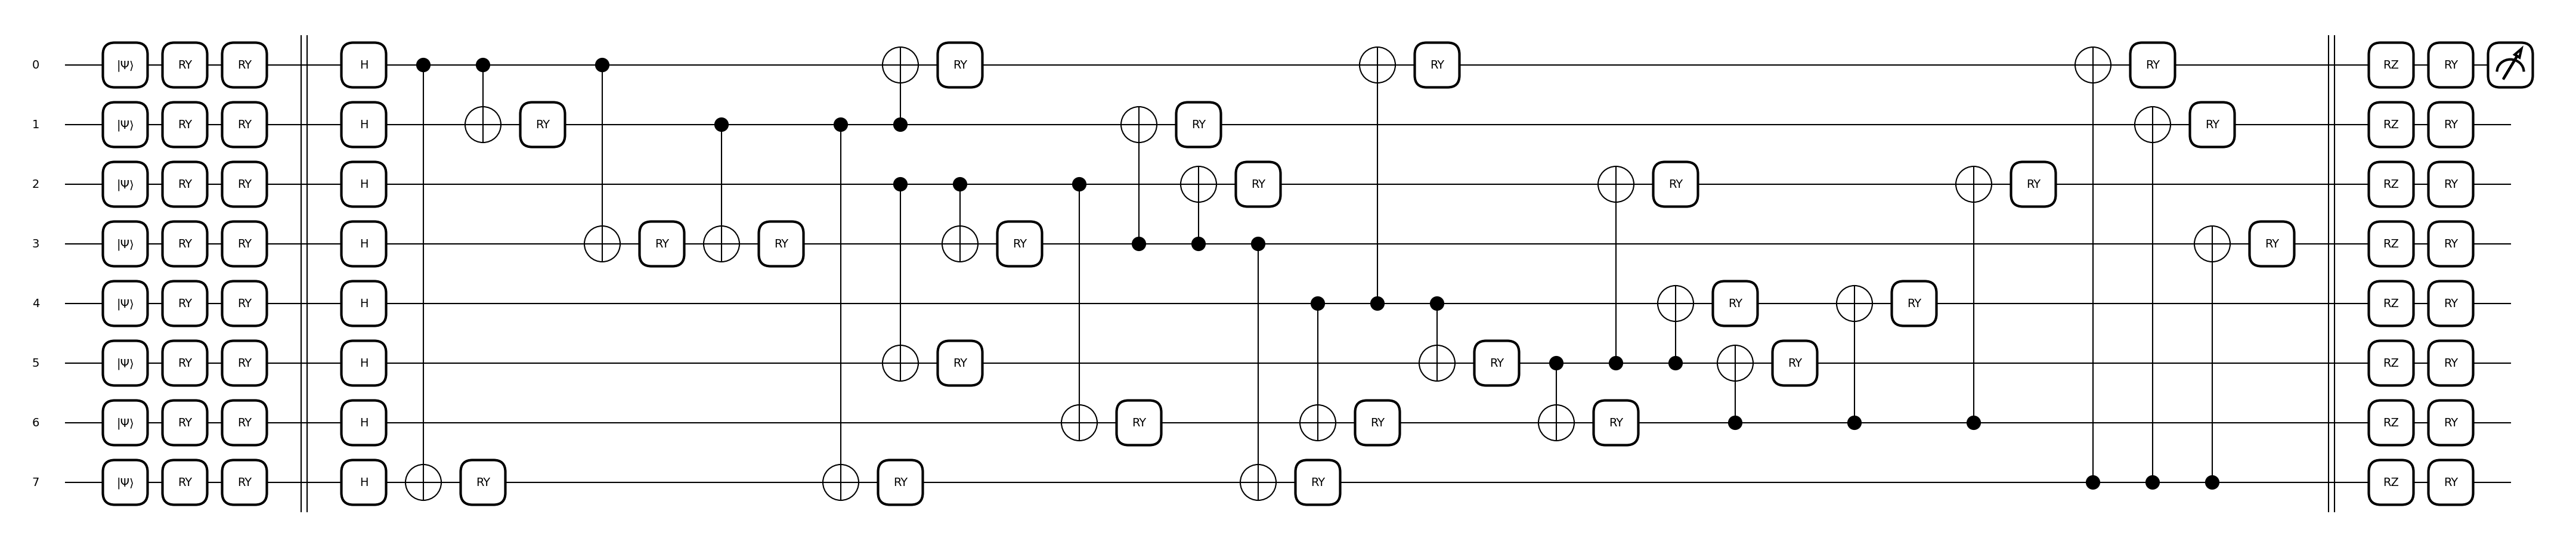

In [51]:
qml.draw_mpl(circuit)(max_features, edges, np.random.rand(1))

This can be a possible forward pass circuit, where the weights, and feature vectors (which are chosen randomly now) will play to role on the type of quantum circuits chosen and the type of Qubit rotation operators used

### References

used to make an informed guess on the subject

1. Benjamin Collis, Saahil Patel, Daniel Koch, Massimiliano Cutugno, Laura Wessing, Paul M. Alsing; Physics simulation via quantum graph neural network. AVS Quantum Sci. 1 June 2023; 5 (2): 023801. https://doi.org/10.1116/5.0145722

On physics-informed neural networks for quantum computers, Frontiers in Applied Mathematics and Statistics, Volume 8. 2022. https://www.frontiersin.org/articles/10.3389/fams.2022.1036711